In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
!pip install optuna > /dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

<ipython-input-2-5a75b75e8aa4>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style='seaborn')


In [3]:
tf.random.set_seed(47)
np.random.seed(47)

In [4]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [5]:
plt.rcParams['figure.figsize'] = (16,6)

In [6]:
from google.colab import files
uploaded = files.upload()

Saving NOW.csv to NOW.csv


In [7]:
df = pd.read_csv('NOW.csv')
df['Date'] = pd.to_datetime(df.Date)

In [8]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date       Open      Close        Low       High  Adj Close
0 2012-07-02  24.750000  24.770000  24.100000  25.200001  24.770000
1 2012-07-03  24.850000  25.309999  24.600000  25.320000  25.309999
2 2012-07-05  25.500000  25.959999  25.139999  26.260000  25.959999
3 2012-07-06  25.750000  25.840000  25.100000  26.120001  25.840000
4 2012-07-09  25.959999  25.270000  25.180000  26.299999  25.270000


In [9]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,2011,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000
mean,2016-06-30 15:42:20.228741888,120.576231,120.666589,118.633551,122.464640,120.666589
min,2012-07-02 00:00:00,23.299999,23.740000,22.620001,24.469999,23.740000
25%,2014-07-02 12:00:00,58.875000,58.850001,57.830000,59.985001,58.850001
50%,2016-06-30 00:00:00,78.769997,78.830002,77.769997,79.669998,78.830002
75%,2018-06-28 12:00:00,174.970001,175.154999,171.824997,177.840003,175.154999
max,2020-06-29 00:00:00,408.000000,402.820007,398.440002,409.799988,402.820007
std,NaN,89.176627,89.248083,87.623149,90.644109,89.248083


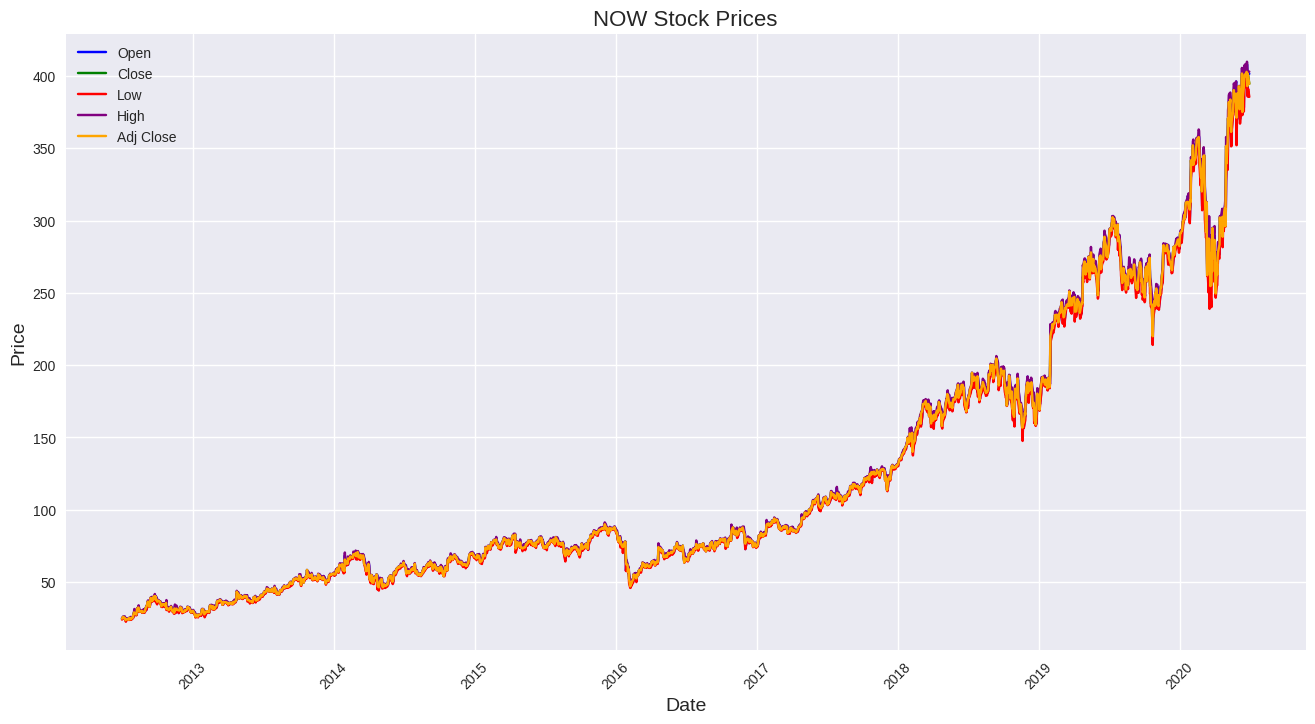

In [11]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('NOW Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [12]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date       Open      Close        Low       High  Adj Close  \
0 2012-07-03  24.850000  25.309999  24.600000  25.320000  25.309999   
1 2012-07-05  25.500000  25.959999  25.139999  26.260000  25.959999   
2 2012-07-06  25.750000  25.840000  25.100000  26.120001  25.840000   
3 2012-07-09  25.959999  25.270000  25.180000  26.299999  25.270000   
4 2012-07-10  25.219999  25.049999  25.049999  25.690001  25.049999   

   avg_price   returns  
0  25.078000  1.456426  
1  25.763999  2.735465  
2  25.730000 -0.131964  
3  25.596000 -0.520795  
4  25.211999 -1.500235  


In [13]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date       Open      Close        Low       High  Adj Close   returns
0 2012-07-03  24.850000  25.309999  24.600000  25.320000  25.309999  1.456426
1 2012-07-05  25.500000  25.959999  25.139999  26.260000  25.959999  2.735465
2 2012-07-06  25.750000  25.840000  25.100000  26.120001  25.840000 -0.131964
3 2012-07-09  25.959999  25.270000  25.180000  26.299999  25.270000 -0.520795
4 2012-07-10  25.219999  25.049999  25.049999  25.690001  25.049999 -1.500235


In [14]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (2010, 7)
[[Timestamp('2012-07-03 00:00:00') 24.85 25.309999 ... 25.32 25.309999
  1.4564260744685864]
 [Timestamp('2012-07-05 00:00:00') 25.5 25.959999 ... 26.26 25.959999
  2.735464594233439]
 [Timestamp('2012-07-06 00:00:00') 25.75 25.84 ... 26.120001 25.84
  -0.13196398382154806]
 ...
 [Timestamp('2020-06-25 00:00:00') 391.720001 401.640015 ... 401.690002
  401.640015 0.13133309960349226]
 [Timestamp('2020-06-26 00:00:00') 401.829987 399.970001 ... 402.839996
  399.970001 0.6729353923885295]
 [Timestamp('2020-06-29 00:00:00') 401.480011 394.549988 ... 402.98999
  394.549988 -0.8327944336636861]]


In [15]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (2010, 6)
[[ 2.48500000e+01  2.53099990e+01  2.46000000e+01  2.53200000e+01
   2.53099990e+01  1.45642607e+00]
 [ 2.55000000e+01  2.59599990e+01  2.51399990e+01  2.62600000e+01
   2.59599990e+01  2.73546459e+00]
 [ 2.57500000e+01  2.58400000e+01  2.51000000e+01  2.61200010e+01
   2.58400000e+01 -1.31963984e-01]
 ...
 [ 3.91720001e+02  4.01640015e+02  3.85660004e+02  4.01690002e+02
   4.01640015e+02  1.31333100e-01]
 [ 4.01829987e+02  3.99970001e+02  3.91079987e+02  4.02839996e+02
   3.99970001e+02  6.72935392e-01]
 [ 4.01480011e+02  3.94549988e+02  3.85500000e+02  4.02989990e+02
   3.94549988e+02 -8.32794434e-01]]


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(1909, 6)
(50, 6)
(51, 6)


In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 1908
Validation Samples: 49
Test Samples: 50


In [22]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [23]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(1908,) (49,) (50,)


In [24]:
x_train[1], y_train[0]

(array([[0.00681748, 0.00676231, 0.00782851, 0.00542145, 0.00676231,
         0.61544803]]),
 0.00681748061103972)

In [25]:
x_val[1], y_val[0]

(array([[0.9814379 , 0.96853396, 0.96756756, 0.96420024, 0.96853396,
         0.50504532]]),
 0.9814378990348996)

In [26]:
x_test[1], y_test[0]

(array([[0.85184382, 0.84900543, 0.85113394, 0.85916347, 0.84900543,
         0.55170735]]),
 0.8518438244442398)

In [27]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [28]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, Dense, Dropout, Reshape, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np

In [29]:
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]

    x_train_reshaped = x_train.reshape((x_train.shape[0], n_timesteps, 1, n_features, 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], n_timesteps, 1, n_features, 1))

    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                         input_shape=(n_timesteps, 1, n_features, 1),
                         return_sequences=True, padding='same'))

    model.add(Reshape((-1, 64)))
    model.add(Flatten())
    # Change the number of units in the Dense layer to match the shape of y_train or y_val
    model.add(Dense(units=1))  # Output a single value for each input
    model.add(Dropout(0.2))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-07-03 09:26:37,038] A new study created in memory with name: no-name-c483f3bc-93eb-4081-88ad-655f493ec99a


2/2 [==============================] - 0s 13ms/step


[I 2024-07-03 09:28:06,127] Trial 1 finished with value: 0.1787170505968989 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.007997370811480583, 'epochs': 52, 'batch_size': 32}. Best is trial 1 with value: 0.1787170505968989.


2/2 [==============================] - 1s 6ms/step


[I 2024-07-03 09:28:09,062] Trial 0 finished with value: 0.17493515448296562 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0012851069937737172, 'epochs': 68, 'batch_size': 16}. Best is trial 0 with value: 0.17493515448296562.


2/2 [==============================] - 0s 8ms/step


[I 2024-07-03 09:28:55,359] Trial 3 finished with value: 0.1630064637787126 and parameters: {'optimizer': 'Adam', 'learning_rate': 4.1101508940684286e-05, 'epochs': 66, 'batch_size': 16}. Best is trial 3 with value: 0.1630064637787126.


2/2 [==============================] - 0s 8ms/step


[I 2024-07-03 09:29:47,652] Trial 2 finished with value: 0.17381149604349236 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.005599408735958474, 'epochs': 122, 'batch_size': 32}. Best is trial 3 with value: 0.1630064637787126.


2/2 [==============================] - 0s 11ms/step


[I 2024-07-03 09:30:21,121] Trial 4 finished with value: 0.17077445355047213 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.0003451781369255474, 'epochs': 138, 'batch_size': 16}. Best is trial 3 with value: 0.1630064637787126.


2/2 [==============================] - 0s 11ms/step


[I 2024-07-03 09:30:48,861] Trial 6 finished with value: 0.17164533865324302 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 6.640540650249116e-05, 'epochs': 134, 'batch_size': 64}. Best is trial 3 with value: 0.1630064637787126.


2/2 [==============================] - 0s 11ms/step


[I 2024-07-03 09:31:33,215] Trial 5 finished with value: 0.1690503823166862 and parameters: {'optimizer': 'Adam', 'learning_rate': 5.923376216844201e-05, 'epochs': 159, 'batch_size': 32}. Best is trial 3 with value: 0.1630064637787126.


2/2 [==============================] - 0s 12ms/step


[I 2024-07-03 09:32:31,328] Trial 8 finished with value: 0.1595142157860644 and parameters: {'optimizer': 'Adam', 'learning_rate': 4.127226712316329e-05, 'epochs': 65, 'batch_size': 32}. Best is trial 8 with value: 0.1595142157860644.


2/2 [==============================] - 0s 8ms/step


[I 2024-07-03 09:33:12,405] Trial 9 finished with value: 0.15721235332570785 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.005935136178930517, 'epochs': 65, 'batch_size': 32}. Best is trial 9 with value: 0.15721235332570785.


2/2 [==============================] - 0s 8ms/step


[I 2024-07-03 09:34:14,869] Trial 7 finished with value: 0.1734985141163288 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00034143555288347545, 'epochs': 114, 'batch_size': 16}. Best is trial 9 with value: 0.15721235332570785.


Best trial: FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.15721235332570785], datetime_start=datetime.datetime(2024, 7, 3, 9, 32, 31, 331011), datetime_complete=datetime.datetime(2024, 7, 3, 9, 33, 12, 404179), params={'optimizer': 'RMSprop', 'learning_rate': 0.005935136178930517, 'epochs': 65, 'batch_size': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=9, value=None)


In [30]:
best_params = study.best_params
best_params

{'optimizer': 'RMSprop',
 'learning_rate': 0.005935136178930517,
 'epochs': 65,
 'batch_size': 32}

<ipython-input-31-5e561eacd0f0>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


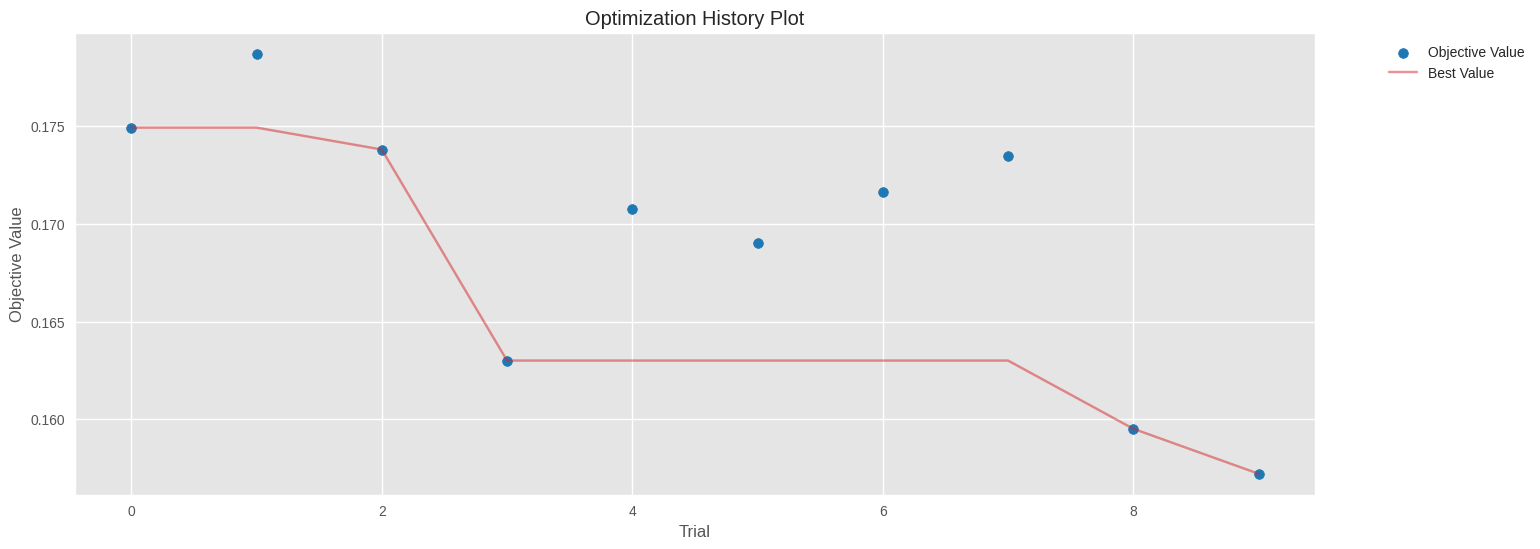

In [31]:
plot_optimization_history(study);

<ipython-input-32-f64c2706aaf1>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


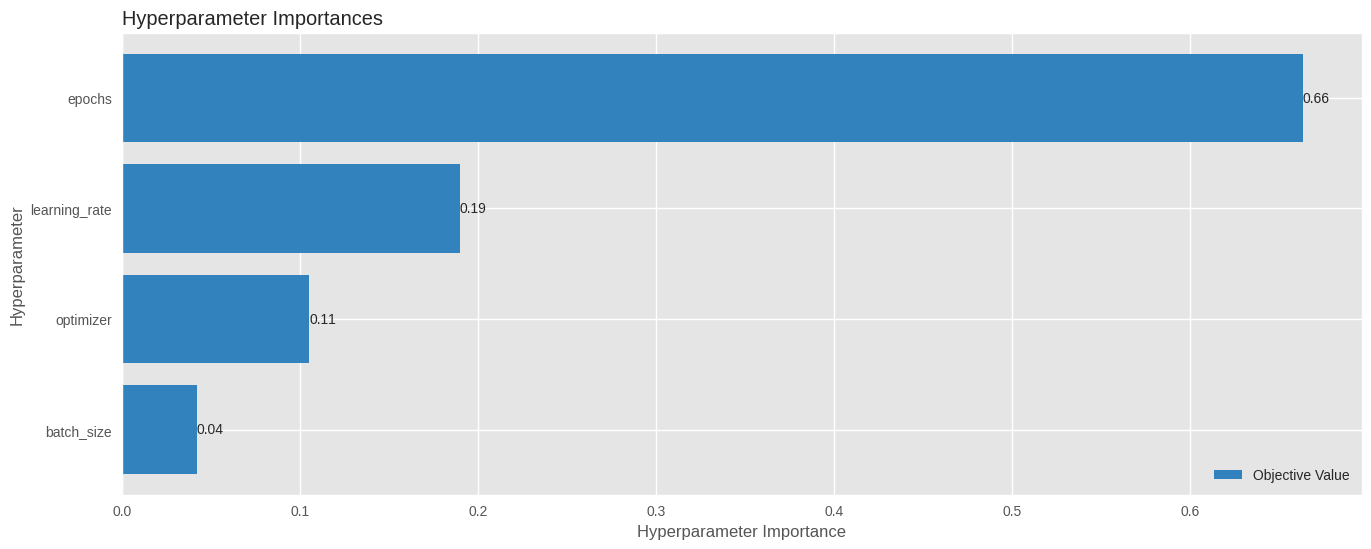

In [32]:
plot_param_importances(study);

In [33]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [34]:
# Retrieve the best hyperparameters obtained from Optuna
best_params = {
    'optimizer': 'Adam',
    'learning_rate': 0.00041510484206477095,
    'epochs': 173,
    'batch_size': 64,
    'units': 64, # Add the number of LSTM units to best_params
    'dropout_rate': 0.2 # Add a dropout rate if needed
}

# Define the LSTM model using the best hyperparameters
model = Sequential()
model.add(LSTM(units=best_params["units"], input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=best_params["dropout_rate"]))
model.add(Dense(units=1))

# Compile the model with the best optimizer and learning rate
if best_params['optimizer'] == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


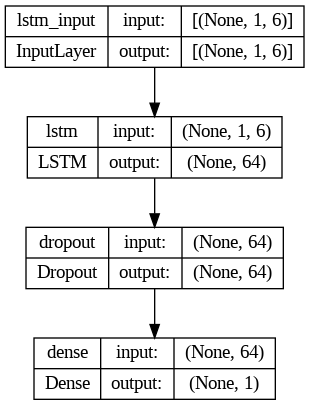

In [35]:
plot_model(model, show_shapes=True)

In [36]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 28.3 s, sys: 1.94 s, total: 30.3 s
Wall time: 42.5 s


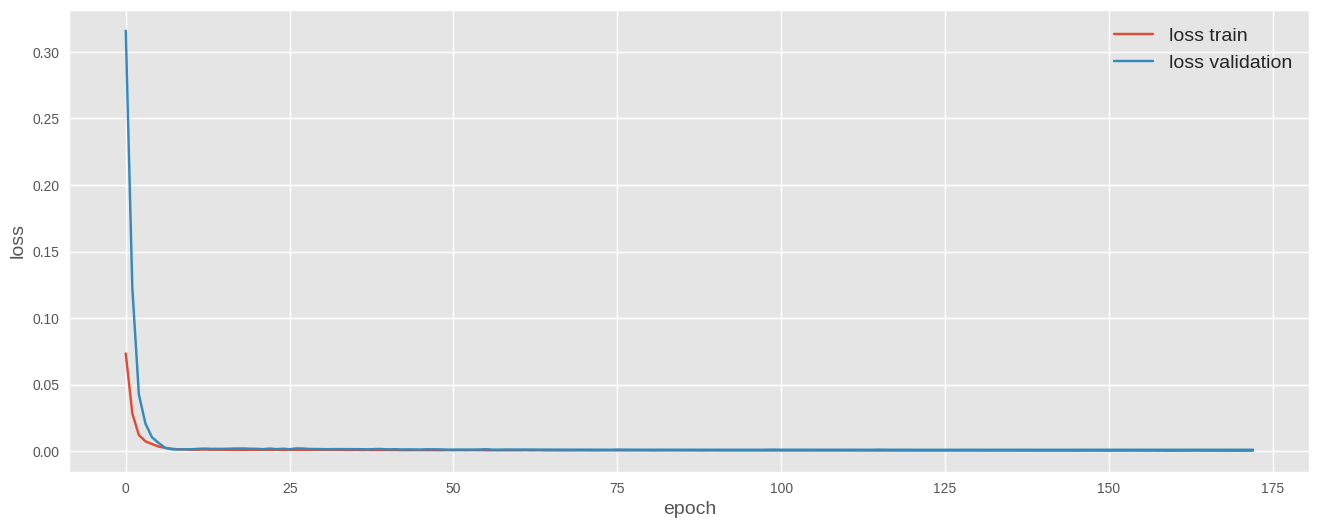

In [37]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [38]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

1/1 [==============================] - 0s 24ms/step - loss: 4.4330e-04 - accuracy: 0.0000e+00


[0.00044330081436783075, 0.0]

In [39]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

2/2 [==============================] - 0s 5ms/step


In [40]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(1908,) (50,)


In [41]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [25.30975054 25.72403828 26.21973571 26.16120056 26.02188807]
Train Actual:  [26. 26. 26. 25. 25.]
Test Predicted:  [299.64178053 300.86608976 289.20983955 297.99142892 298.10710471]
Test Actual:  [298. 299. 296. 300. 298.]


In [42]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.20 RMSE
Test Score: 6.82 RMSE


In [43]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

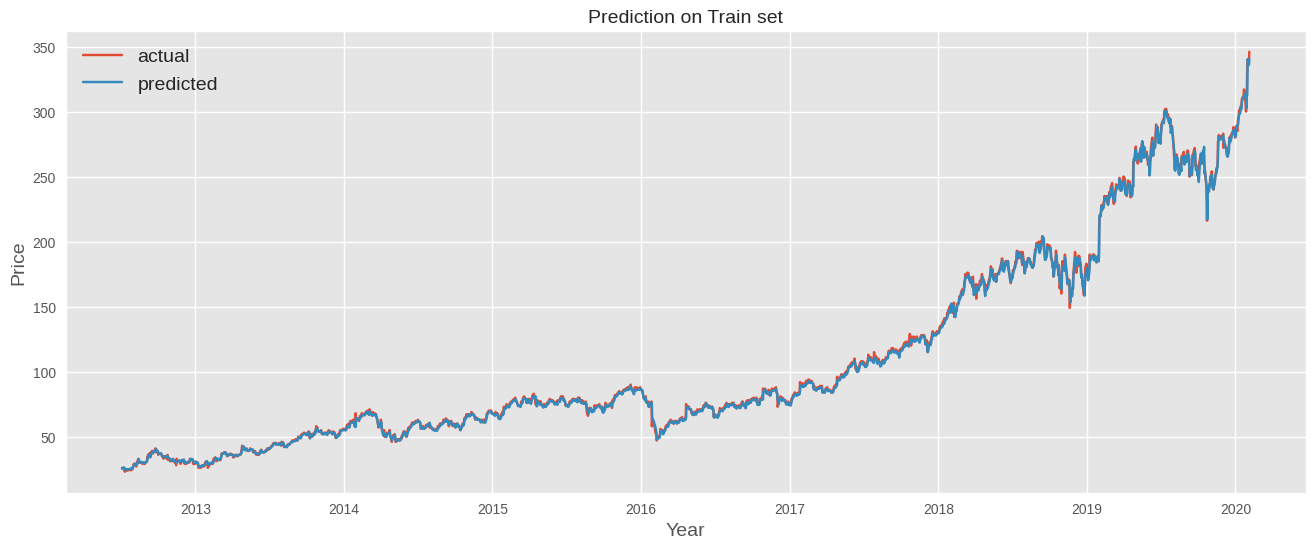

In [44]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

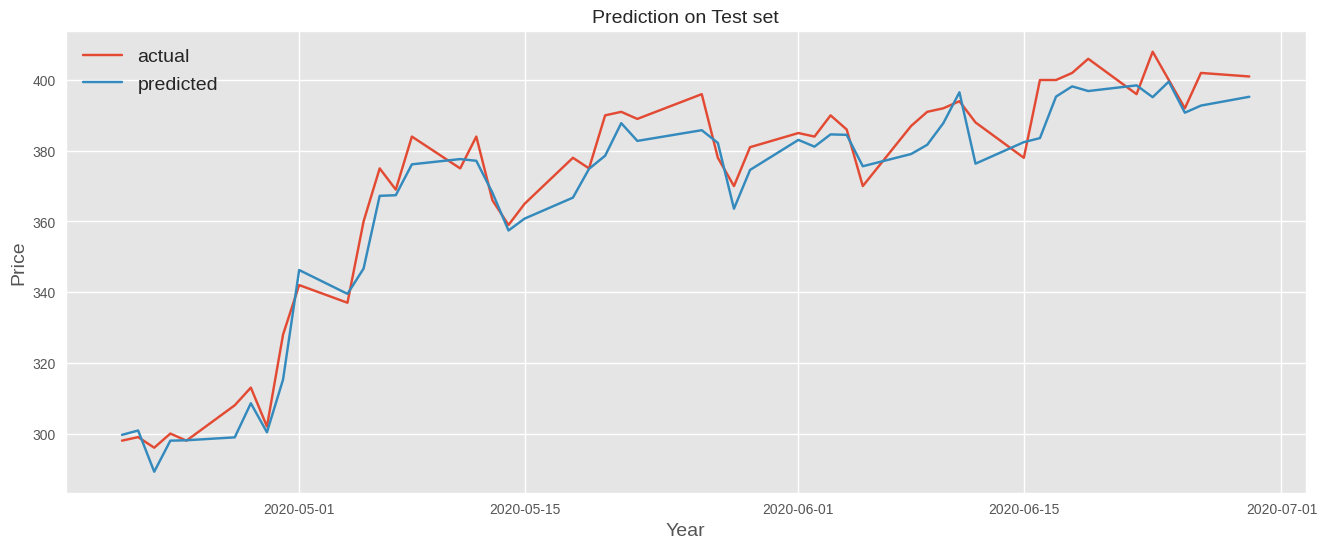

In [45]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [50]:
yhat_test

array([299.64178053, 300.86608976, 289.20983955, 297.99142892,
       298.10710471, 298.93141497, 308.57670669, 300.36907238,
       315.28601823, 346.25662562, 339.51365384, 346.66743434,
       367.24187676, 367.41402481, 376.1497978 , 377.6322714 ,
       377.15006452, 368.14012413, 357.44174798, 360.79992364,
       366.73066438, 374.87432501, 378.5908379 , 387.80100859,
       382.77428555, 385.80505294, 382.20810119, 363.60003188,
       374.57057506, 383.06207093, 381.15363188, 384.61825082,
       384.48991878, 375.60450202, 379.0651202 , 381.67280732,
       387.78800613, 396.52389451, 376.3395261 , 382.42329587,
       383.56751299, 395.30689436, 398.19682733, 396.87888495,
       398.4796887 , 395.14109367, 399.54315972, 390.75160692,
       392.76879738, 395.25626937])

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 46.45756849640907
Root Mean Squared Error (RMSE): 6.8159789096217915
Mean Absolute Error (MAE): 5.556412431065812
R-squared (R2) Score: 0.9591220436313552
Mean Absolute Percentage Error (MAPE): 1.49%


In [47]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: 1.43%
Mean Squared Error (MSE) on Training set: 4.82
Root Mean Squared Error (RMSE) on Training set: 2.20
Mean Absolute Error (MAE) on Training set: 1.37
R-squared (R2) Score on Training set: 1.00


In [48]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.99


In [49]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: 0.99
